<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/08_Taxifare_Keras_FeatureColumns_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras Feature Columns are not an officially released feature yet. Some caveats apply: please run this notebook on a GPU Backend. Keras Feature Columns are not comaptible with TPUs yet. Also, you will not be able to export this model to Tensorflow's "saved model" format for serving. The serving layer for feature columns will be added soon.


## Imports

In [0]:
import os, json, math
import numpy as np
import tensorflow as tf
from tensorflow.python.feature_column import feature_column_v2 as fc  # This will change when Keras FeatureColumn is final.
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()

Tensorflow version 1.12.0


In [0]:
#@title display utilities [RUN ME]
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Colab-only auth

In [0]:
# backend identification
IS_COLAB = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ

# Auth on Colab
if IS_COLAB:
  from google.colab import auth
  auth.authenticate_user()
  
# Also propagate the Auth to TPU if available so that it can access your GCS buckets
if IS_COLAB and HAS_COLAB_TPU:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
  with tf.Session(TF_MASTER) as sess:    
    with open('/content/adc.json', 'r') as f:
      auth_info = json.load(f) # Upload the credentials to TPU.
    tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)
  print('Using TPU')

# TPU usage flag
USE_TPU = HAS_COLAB_TPU

## Config

In [0]:
DATA_BUCKET = "gs://cloud-training-demos/taxifare/"
TRAIN_DATA_PATTERN = DATA_BUCKET + "train*"
VALID_DATA_PATTERN = DATA_BUCKET + "valid*"

In [0]:
CSV_COLUMNS = ['fare_amount', 'dayofweek', 'hourofday', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']
DEFAULTS = [[0.0], ['null'], [12], [-74.0], [40.0], [-74.0], [40.7], [1.0], ['nokey']]

def decode_csv(line):
  column_values = tf.decode_csv(line, DEFAULTS)
  column_names = CSV_COLUMNS
  decoded_line = dict(zip(column_names, column_values)) # create a dictionary {'column_name': value, ...} for each line  
  return decoded_line

def load_dataset(pattern):
  #filenames = tf.gfile.Glob(pattern)
  filenames = tf.data.Dataset.list_files(pattern)
  #dataset = tf.data.TextLineDataset(filenames)
  dataset = filenames.interleave(tf.data.TextLineDataset, cycle_length=16)  # interleave so that reading happens from multiple files in parallel
  dataset = dataset.map(decode_csv)
  return dataset

In [0]:
dataset = load_dataset(TRAIN_DATA_PATTERN)
for n, data in enumerate(dataset):
  numpy_data = {k: v.numpy() for k, v in data.items()} # .numpy() works in eager mode
  print(numpy_data)
  if n>10: break

{'fare_amount': 9.7, 'dayofweek': b'Wed', 'hourofday': 9, 'pickuplon': -73.958984, 'pickuplat': 40.767925, 'dropofflon': -73.977974, 'dropofflat': 40.74173, 'passengers': 1.0, 'key': b'2010-04-14 09:39:00.000000-73.95940.767940.7417-73.978'}
{'fare_amount': 24.9, 'dayofweek': b'Fri', 'hourofday': 23, 'pickuplon': -73.977684, 'pickuplat': 40.763264, 'dropofflon': -73.97954, 'dropofflat': 40.66857, 'passengers': 4.0, 'key': b'2010-01-22 23:48:20.000000-73.977740.763340.6686-73.9795'}
{'fare_amount': 9.3, 'dayofweek': b'Fri', 'hourofday': 19, 'pickuplon': -73.994225, 'pickuplat': 40.719498, 'dropofflon': -73.97495, 'dropofflat': 40.744637, 'passengers': 3.0, 'key': b'2010-12-17 19:35:00.000000-73.994240.719540.7446-73.975'}
{'fare_amount': 16.5, 'dayofweek': b'Fri', 'hourofday': 16, 'pickuplon': -73.98174, 'pickuplat': 40.749756, 'dropofflon': -74.00382, 'dropofflat': 40.737328, 'passengers': 1.0, 'key': b'2014-04-25 16:43:00.000000-73.981740.749840.7373-74.0038'}
{'fare_amount': 5.7, 'da

In [0]:
def add_engineered(features):
    # this is how you can do feature engineering in TensorFlow
    distance = tf.sqrt((features['pickuplat'] - features['dropofflat'])**2 +
                       (features['pickuplon'] - features['dropofflon'])**2)
    
    # euclidian distance is hard for a neural network to emulate
    features['euclidean'] = distance
    return features

def features_and_labels(features):
  features = add_engineered(features)
  features.pop('key') # this column not needed
  label = features.pop('fare_amount') # this is what we will train for
  return features, label
  
def prepare_dataset(dataset, batch_size, truncate=None, shuffle=True):
  dataset = dataset.map(features_and_labels)
  if truncate is not None:
    dataset = dataset.take(truncate)
  dataset = dataset.cache()
  if shuffle:
    dataset = dataset.shuffle(10000)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(-1) # prefetch next batch while training (-1: autotune prefetch buffer size)
  return dataset

one_item = load_dataset(TRAIN_DATA_PATTERN).map(features_and_labels).take(1).batch(1)

## Linear Keras model [WORK REQUIRED]
1. What do the columns do ? Familiarize yourself with these column types.

`numeric_col = fc.`[`numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column)`('name')`

`bucketized_numeric_col = fc.`[`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column)`(fc.`[`numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column)`('name'), [0, 2, 10])`


`indic_of_categ_col = fc.`[`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column)`(fc.`[`categorical_column_with_identity`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_identity)`('name', num_buckets = 24))`

`indic_of_categ_vocab_col = fc.`[`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column)`(fc.`[`categorical_column_with_identity`](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list)`('color', vocabulary_list = ['red', 'blue']))` 


`indic_of_crossed_col = fc.`[`indicator_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column)`(fc.`[`crossed_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column)`([categcol1, categcol2], 16*16))`


`embedding_of_crossed_col = fc.`[`embedding_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column)`(fc.`[`crossed_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column)`([categcol1, categcol2], 16*16), 5)`

| column | output vector shape | nb of parameters |
|--------------|---------------------------------|------------------------------|
| numeric_col | [1] | 0 |
| bucketized_numeric_col | [bucket boundaries+1] | 0 |
| indic_of_categ_col | [nb categories] | 0 |
| indic_of_categ_vocab_col | [nb categories] | 0 |
| indic_of_crossed_col | [nb crossed categories] | 0 |
| embedding_of_crossed_col | [nb crossed categories] | crossed categories * embedding size |

2. Let's start with all the data in as simply as possible: numerical columns for numerical values, categorical (one-hot encoded) columns for categorical data like the day of the week or the hour of the day. Try training...
 * RSME flat at 8-9 ... not good
3. Try to replace the numerical latitude and longitudes by their bucketized versions
 * RSME trains to 6 ... progress!
4. Try to add an engineered feature like 'euclidean' for the distance traveled by the taxi
 * RMSE trains down to 4-5 ... progress !
 The euclidian distance is really hard to emulate for a neural network. Look through the code to see how it was "engineered".
5. Now add embedded crossed columns for:
  * hourofday x dayofweek
   * pickup neighborhood (bucketized pickup lon x bucketized pickup lat)
   * dropoff neighborhood (bucketized dropoff lon x bucketized dropoff lat)
   * is this better ?
   
The big wins were bucketizing the coordinates and adding the euclidian distance. The cross column add only a little, and only if you train for longer. Try training on 10x the training and validation data. With crossed columns you should be able to reach RMSE=3.9

In [0]:
NB_BUCKETS = 16
latbuckets = np.linspace(38.0, 42.0, NB_BUCKETS).tolist()
lonbuckets = np.linspace(-76.0, -72.0, NB_BUCKETS).tolist()


# the columns you can play with

# Categorical columns are used as:
# fc.indicator_column(dayofweek)
dayofweek = fc.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat'])
hourofday = fc.categorical_column_with_identity('hourofday', num_buckets = 24)

# Bucketized columns can be used as such:
bucketized_pick_lat = fc.bucketized_column(fc.numeric_column('pickuplon'), lonbuckets)
bucketized_pick_lon = fc.bucketized_column(fc.numeric_column('pickuplat'), latbuckets)
bucketized_drop_lat = fc.bucketized_column(fc.numeric_column('dropofflon'), lonbuckets)
bucketized_drop_lon = fc.bucketized_column(fc.numeric_column('dropofflat'), latbuckets)

# Cross columns are used as
# fc.embedding_column(day_hr, 5)
day_hr =  fc.crossed_column([dayofweek, hourofday], 24 * 7)
pickup_cross  = fc.crossed_column([bucketized_pick_lat, bucketized_pick_lon], NB_BUCKETS * NB_BUCKETS)
drofoff_cross = fc.crossed_column([bucketized_drop_lat, bucketized_drop_lon], NB_BUCKETS * NB_BUCKETS)
#pickdorp_pair  = fc.crossed_column([pickup_cross, ddropoff_cross], NB_BUCKETS ** 4 )
  
columns = [
    # Categorical columns       
    fc.indicator_column(dayofweek),
    fc.indicator_column(hourofday),
    # Bucketized columns
    bucketized_plat,
    bucketized_plon,
    bucketized_dlat,
    bucketized_dlon,
    # Numeric columns
    fc.numeric_column('passengers'),
    #fc.numeric_column('pickuplon'), # replaced by bucketized
    #fc.numeric_column('pickuplat'), # replaced by bucketized
    #fc.numeric_column('dropofflon'), # replaced by bucketized
    #fc.numeric_column('dropofflat'), # replaced by bucketized
    # Engineered features that are created in the input_fn
    fc.numeric_column('euclidean'),
    # Feature crosses
    #fc.embedding_column(pd_pair, 5),
    fc.embedding_column(pickup_cross, 5),
    fc.embedding_column(drofoff_cross, 5),
    fc.embedding_column(day_hr, 5)
]

l = tf.keras.layers
model = tf.keras.Sequential(
    [
        fc.FeatureLayer(columns),
        l.Dense(100, activation='relu'),
        l.Dense(64, activation='relu'),
        l.Dense(32, activation='relu'),
        l.Dense(16, activation='relu'),
        l.Dense(1, activation=None), # regression
    ])

def rmse(y_true, y_pred): # Root Mean Squared Error
  return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def mae(y_true, y_pred): # Mean Squared Error
  return tf.reduce_mean(tf.abs(y_pred - y_true))
  
model.compile(optimizer=tf.train.AdamOptimizer(), # little bug: in eager mode, 'adam' is not yet accepted, must spell out tf.train.AdamOptimizer()
              loss='mean_squared_error',
              metrics=[rmse])

# print model layers
model.predict(one_item, steps=1) # little bug: with FeatureLayer, must call the model once on dummy data before .summary can work
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_layer_14 (FeatureLay multiple                  3400      
_________________________________________________________________
dense_70 (Dense)             multiple                  11700     
_________________________________________________________________
dense_71 (Dense)             multiple                  6464      
_________________________________________________________________
dense_72 (Dense)             multiple                  2080      
_________________________________________________________________
dense_73 (Dense)             multiple                  528       
_________________________________________________________________
dense_74 (Dense)             multiple                  17        
Total params: 24,189
Trainable params: 24,189
Non-trainable params: 0
_________________________________________________________________


In [0]:
EPOCHS = 8
BATCH_SIZE = 512
TRAIN_SIZE = 640*1024  # max is 2,141,023 (1081336 on dataset in ch3)
VALID_SIZE = 64*1024   # max is 2,124,500

# Playground settings: TRAIN_SIZE = 64*1024, VALID_SIZE = 4*1024
# Solution settings: TRAIN_SIZE = 640*1024, VALID_SIZE = 64*1024

# This should reach RMSE = 3.9 (multiple runs may be necessary)

train_dataset = prepare_dataset(load_dataset(TRAIN_DATA_PATTERN), batch_size=BATCH_SIZE, truncate=TRAIN_SIZE)
valid_dataset = prepare_dataset(load_dataset(VALID_DATA_PATTERN), batch_size=BATCH_SIZE, truncate=VALID_SIZE, shuffle=False)

history = model.fit(train_dataset, steps_per_epoch=TRAIN_SIZE//BATCH_SIZE, epochs=EPOCHS, shuffle=True,
                    validation_data=valid_dataset, validation_steps=VALID_SIZE//BATCH_SIZE)

Epoch 1/8
1280/1280 [==============================] - 173s 135ms/step - loss: 30.7648 - rmse: 5.1559 - val_loss: 28.1548 - val_rmse: 5.2704
Epoch 2/8
1280/1280 [==============================] - 126s 98ms/step - loss: 16.1785 - rmse: 3.9372 - val_loss: 18.7065 - val_rmse: 4.2740
Epoch 3/8
1280/1280 [==============================] - 126s 98ms/step - loss: 15.5687 - rmse: 3.8749 - val_loss: 18.7203 - val_rmse: 4.2782
Epoch 4/8
1280/1280 [==============================] - 125s 98ms/step - loss: 15.4350 - rmse: 3.8553 - val_loss: 17.7775 - val_rmse: 4.1650
Epoch 5/8
1280/1280 [==============================] - 126s 99ms/step - loss: 15.3527 - rmse: 3.8456 - val_loss: 16.9962 - val_rmse: 4.0689
Epoch 6/8
1280/1280 [==============================] - 124s 97ms/step - loss: 15.2627 - rmse: 3.8340 - val_loss: 17.6711 - val_rmse: 4.1534
Epoch 7/8
1280/1280 [==============================] - 125s 98ms/step - loss: 15.2182 - rmse: 3.8284 - val_loss: 16.3498 - val_rmse: 3.9871
Epoch 8/8
1280/1280

dict_keys(['val_loss', 'val_rmse', 'loss', 'rmse'])


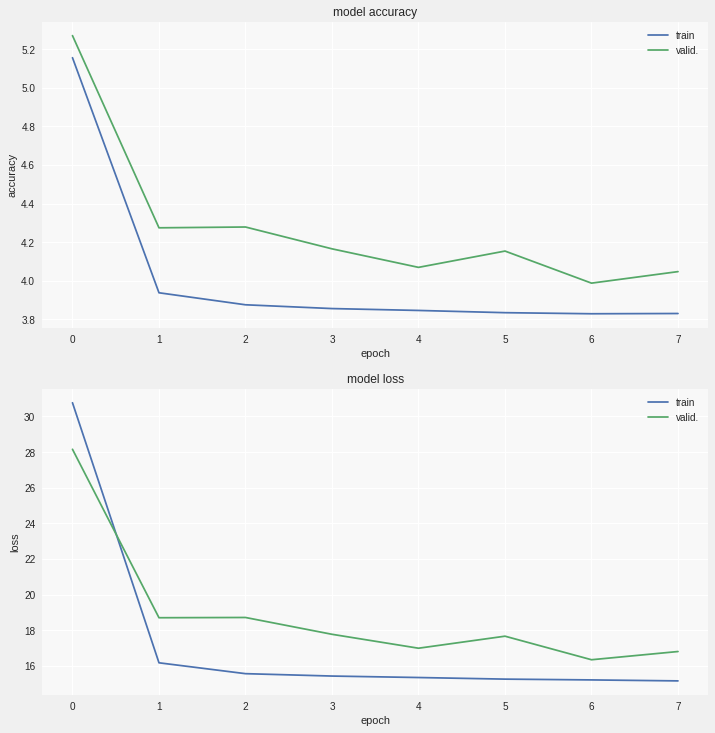

In [0]:
print(history.history.keys())
display_training_curves(history.history['rmse'], history.history['val_rmse'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)